<a href="https://colab.research.google.com/github/paolitacute/Computer-Vision-Project-3/blob/main/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Networks**

- Learn local features instead of global features
  - In a MLP, every hidden unit is the response to a global feature (pattern)
  - In a CNN, every local feature (pattern) produces a response map

- PyTorch
  - https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  - https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

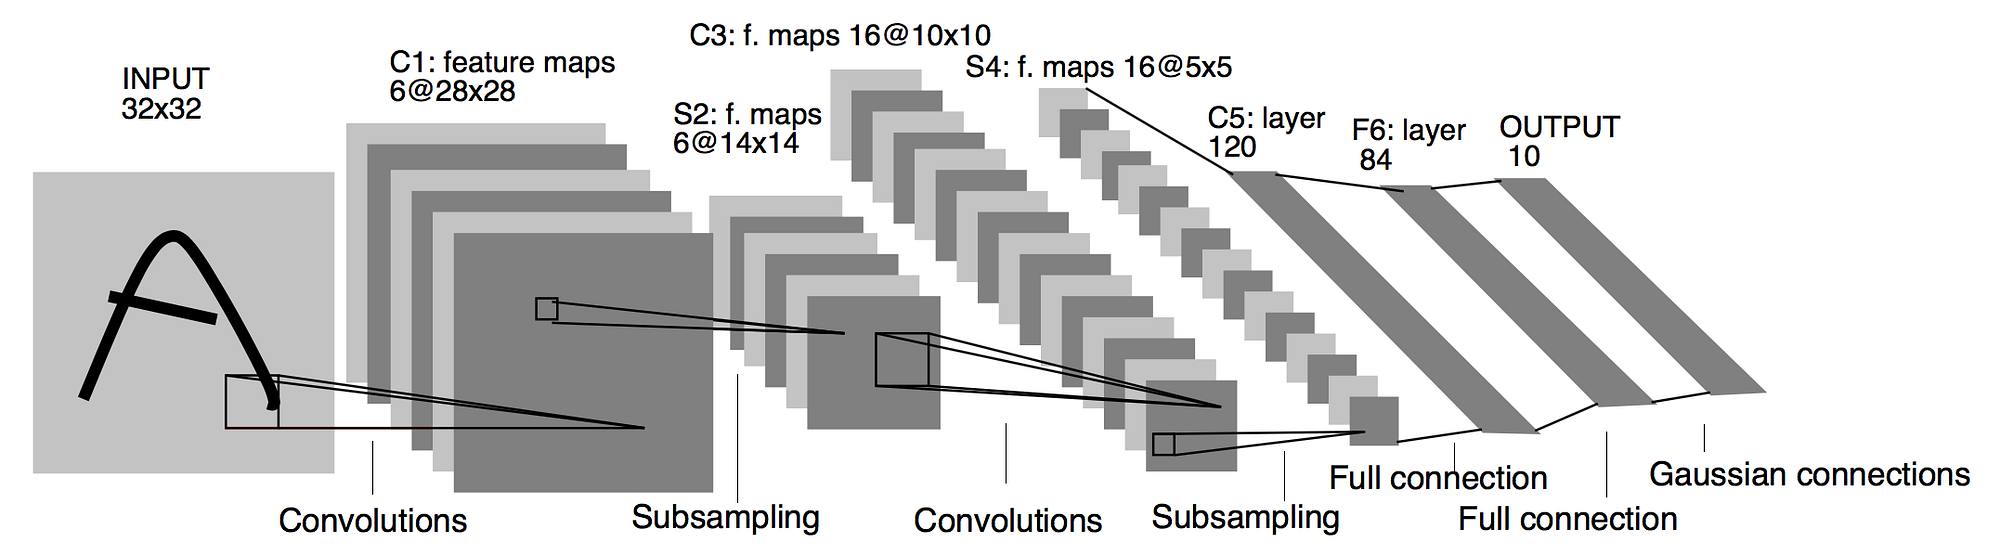

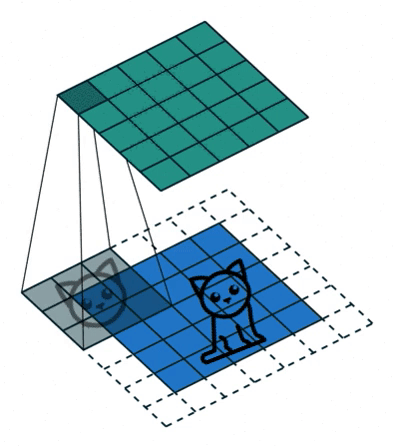

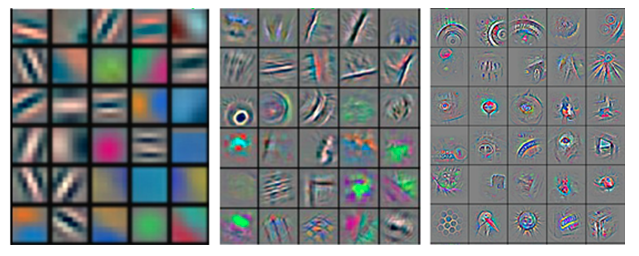

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(4*4*16, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

from keras.datasets import mnist

class MNIST(Dataset):
    def __init__(self, mode='train'):
        (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

        if mode == 'train':
          self.X = (train_images[:50000].reshape(-1, 1, 28, 28) / 255.0).astype(np.float32)
          self.y = train_labels[:50000].astype(np.int64)
        elif mode == 'val':
          self.X = (train_images[50000:].reshape(-1, 1, 28, 28) / 255.0).astype(np.float32)
          self.y = train_labels[50000:].astype(np.int64)
        elif mode == 'test':
          self.X = (test_images.reshape(-1, 1, 28, 28) / 255.0).astype(np.float32)
          self.y = test_labels.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MNIST('train')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for batch in train_dataloader:
    print(batch[0].shape, batch[0].type())
    print(batch[1].shape, batch[1].type())
    break

val_dataset = MNIST('val')
val_dataloader = DataLoader(val_dataset, batch_size=64)

for batch in val_dataloader:
    print(batch[0].shape, batch[0].type())
    print(batch[1].shape, batch[1].type())
    break

test_dataset = MNIST('test')
test_dataloader = DataLoader(test_dataset, batch_size=64)

for batch in test_dataloader:
    print(batch[0].shape, batch[0].type())
    print(batch[1].shape, batch[1].type())
    break


print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
torch.Size([64, 1, 28, 28]) torch.FloatTensor
torch.Size([64]) torch.LongTensor
torch.Size([64, 1, 28, 28]) torch.FloatTensor
torch.Size([64]) torch.LongTensor
torch.Size([64, 1, 28, 28]) torch.FloatTensor
torch.Size([64]) torch.LongTensor
50000
10000
10000


In [ ]:
from torchsummary import summary

model = CNN()

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [ ]:
model = CNN().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

best_acc = 0.0
for j in range(50):

  model.train()

  running_loss = 0.0
  count = 0
  for i, data in enumerate(train_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data

    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(inputs.cuda())

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels.cuda())
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather data and report
    running_loss += loss.item()
    count += 1

  print('loss: {}'.format(running_loss / count))

  model.eval()

  acc = 0
  for data in val_dataloader:
    inputs, labels = data
    with torch.no_grad():
      outputs = model(inputs.cuda())
      _, predicted = torch.max(outputs.data, 1)
      acc += (predicted == labels.cuda()).sum().item()
  acc /= len(val_dataset)
  print('Val accuracy:', acc)

  if acc > best_acc:
    print('Best')
    best_acc = acc
    torch.save(model.state_dict(), 'best_model.pth')

model.eval()

model.load_state_dict(torch.load('best_model.pth'))

acc = 0
for data in test_dataloader:
  inputs, labels = data
  with torch.no_grad():
    outputs = model(inputs.cuda())
    _, predicted = torch.max(outputs.data, 1)
    acc += (predicted == labels.cuda()).sum().item()
acc /= len(test_dataset)
print('Test accuracy:', acc)

loss: 0.31352884533679315
Val accuracy: 0.9666
Best
loss: 0.09091965352659069
Val accuracy: 0.9779
Best
loss: 0.06487511586644412
Val accuracy: 0.9798
Best
loss: 0.050801064531334324
Val accuracy: 0.9828
Best
loss: 0.04057830459628221
Val accuracy: 0.9784
loss: 0.035954945385219386
Val accuracy: 0.9833
Best
loss: 0.02978252000977819
Val accuracy: 0.9866
Best
loss: 0.025362850864790915
Val accuracy: 0.9879
Best
loss: 0.022561786006168833
Val accuracy: 0.9855
loss: 0.020253882442089362
Val accuracy: 0.9871
loss: 0.018132628561203727
Val accuracy: 0.9869
loss: 0.014265708063923455
Val accuracy: 0.9901
Best
loss: 0.014668224019376683
Val accuracy: 0.9885
loss: 0.009910953769055696
Val accuracy: 0.9879
loss: 0.012677209972650145
Val accuracy: 0.9875
loss: 0.010151816322987867
Val accuracy: 0.9865
loss: 0.01100948724047099
Val accuracy: 0.9889
loss: 0.009695541177740519
Val accuracy: 0.9878
loss: 0.007031998868218407
Val accuracy: 0.9866
loss: 0.008462720461543139
Val accuracy: 0.9903
Best
l

conv1.weight torch.Size([6, 1, 5, 5])


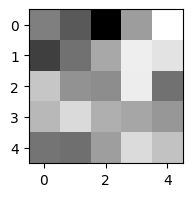

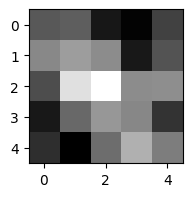

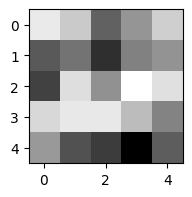

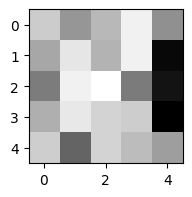

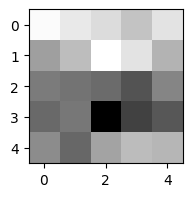

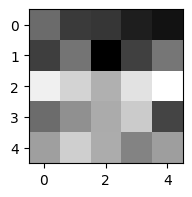

conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
linear1.weight torch.Size([120, 256])
linear1.bias torch.Size([120])
linear2.weight torch.Size([84, 120])
linear2.bias torch.Size([84])
linear3.weight torch.Size([10, 84])
linear3.bias torch.Size([10])


In [ ]:
import matplotlib.pyplot as plt

for name, param in model.named_parameters():
  print(name, param.shape)

  if name == 'conv1.weight':
    for i in range(6):
      img = param[i,0].detach().cpu().numpy()
      plt.figure(figsize=(2, 2))
      plt.imshow(img, cmap='gray')
      plt.show()